# Predicting Next Location in a Sequence using RNN

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
seed = 4020

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Data Processing

In [ ]:
cityA_df = pd.read_csv("data/cityA_groundtruthdata.csv")
# cityB_df = pd.read_csv("data/cityB_challengedata.csv")
# cityC_df = pd.read_csv("data/cityC_challengedata.csv")
# cityD_df = pd.read_csv("data/cityD_challengedata.csv")

In [ ]:
cityA_df['d'].nunique()

75

In [ ]:
cityA_df = cityA_df[cityA_df['uid']<=1000]

In [ ]:
cityA_df

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89
...,...,...,...,...,...
1229248,1000,74,29,79,112
1229249,1000,74,32,83,104
1229250,1000,74,33,80,103
1229251,1000,74,39,74,98


In [ ]:
cityA_train = cityA_df[cityA_df['d']<=30]
cityA_val = cityA_df[
        (cityA_df['d']<=40) &
        (cityA_df['d']>=31)
]
cityA_test = cityA_df[
    (cityA_df['d']<=50) &
    (cityA_df['d']>=41)
    ]

In [ ]:
sequences = (
        cityA_train.sort_values(by=['t'])  # Sort by 't' in ascending order
        .groupby(['uid', 'd'])  # Group by 'uid' and 'd'
        .apply(lambda group: list(zip(group['x'], group['y'])))  # Create list of (x, y) tuples
        .reset_index(name='coordinates')  # Reset index and give the aggregated column a name
)

sequences

,uid,d,coordinates
0,0,0,"[(79, 86), (79, 86), (77, 86), (77, 86), (81, ..."
1,0,1,"[(76, 84), (76, 84), (76, 85), (75, 85), (77, ..."
2,0,2,"[(84, 89), (89, 78), (115, 80), (116, 79), (11..."
3,0,3,"[(81, 88), (83, 94), (85, 95), (88, 94), (90, ..."
4,0,4,"[(77, 86), (80, 87), (85, 95), (85, 91), (82, ..."
...,...,...,...
29029,1000,25,"[(78, 124), (77, 116), (76, 98), (76, 99), (76..."
29030,1000,26,"[(77, 123), (78, 106), (76, 99), (76, 97), (89..."
29031,1000,28,"[(83, 132), (85, 132), (84, 132), (83, 133), (..."
29032,1000,29,"[(77, 120), (76, 101), (76, 99), (76, 99), (76..."


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


# Collate function to pad sequences in each batch
def collate_fn(batch):
    sequences, targets = zip(*batch)
    # Pad sequences to the max length in the batch
    padded_sequences = pad_sequence(sequences, batch_first=True) # pad before the start
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64)  # Get original lengths

    padded_targets = pad_sequence(targets, batch_first=True)  # (batch, max_seq_len, output_dim)
    return padded_sequences, padded_targets, lengths


In [ ]:
def process_df(df, batch_size=32):

    """
    prepares each dataframe for training by loading it into a dataloader of the specified batchsize
    """

    df = df[df['uid']<=1000] # limit to first 1000 uid
    #df['coordinate_id'] = pd.factorize(list(zip(df['x'], df['y'])))[0] #encode into class labels

    sequences = (
        df.sort_values(by=['t'])  # Sort by 't' in ascending order
        .groupby(['uid', 'd'])  # Group by 'uid' and 'd'
        .apply(lambda group: list(zip(group['x'], group['y'])))  # Create list of (x, y) tuples
        .reset_index(name='coordinates')  # Reset index and give the aggregated column a name
)

    sequences['target'] = sequences['coordinates'].apply(lambda coords: coords[-1])  # Last  id
    sequences['coordinates'] = sequences['coordinates'].apply(lambda coords: coords[:-1])  # All except last

    sequences = sequences[(sequences['coordinates'].str.len() > 0)] # remove rows with no train data


    coordinates = sequences['coordinates'].apply(lambda seq: torch.tensor([(x, y) for x, y in seq], dtype=torch.float32))
    targets = sequences['target'].apply(lambda coord: torch.tensor(coord, dtype=torch.float32))

    dataset = SequenceDataset(coordinates.tolist(), torch.stack(targets.tolist()))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return dataloader



In [ ]:
train_loader = process_df(cityA_train)
val_loader = process_df(cityA_val)
test_loader = process_df(cityA_test)

____

# Training RNN Model

___

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class coordRNN(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(coordRNN, self).__init__()
    self.num_layers = num_hidden
    self.hidden_size = hidden_d
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, lengths):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # Pack the padded sequence
    x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    r_packed, h = self.rnn(x_packed, h0)
    # Unpack the sequence
    #r, _ = nn.utils.rnn.pad_packed_sequence(r_packed, batch_first=True)
    last_timestep = h[-1]
    y = self.fc(last_timestep)
    return y

Epoch 1, train loss: 7147.169332794291
Epoch 2, train loss: 2260.1121048734713
Epoch 3, train loss: 1374.5272605448051
Epoch 4, train loss: 1193.301154447584
Epoch 5, train loss: 781.6106262115221
Epoch 6, train loss: 536.3979848846774
Epoch 7, train loss: 432.64743858849533
Epoch 8, train loss: 329.8831471693665
Epoch 9, train loss: 246.2601758498873
Epoch 10, train loss: 204.96506286662583
Epoch 11, train loss: 185.94909661804314
Epoch 12, train loss: 173.9240272428144
Epoch 13, train loss: 165.62289810687685
Epoch 14, train loss: 162.0202880419111
Epoch 15, train loss: 152.89542858190867
Epoch 16, train loss: 149.14584097075883
Epoch 17, train loss: 149.63781155845749
Epoch 18, train loss: 141.65864859134612
Epoch 19, train loss: 149.24627466562222
Epoch 20, train loss: 140.9859729492744
Epoch 21, train loss: 140.8017660553487
Epoch 22, train loss: 140.75430504954826
Epoch 23, train loss: 133.49978228512046
Epoch 24, train loss: 138.7623607026982
Epoch 25, train loss: 141.7616479654

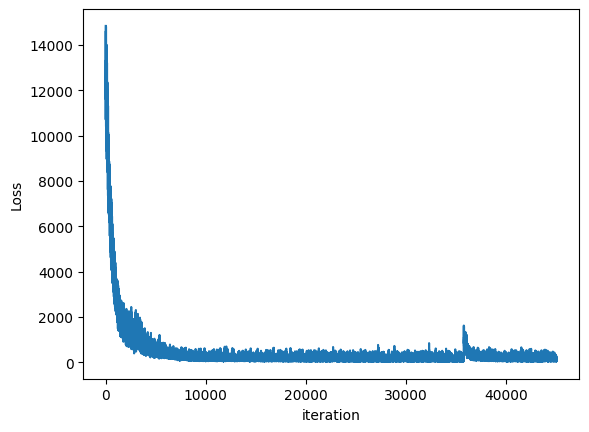

In [ ]:
in_d = 2
out_d = in_d
hidden_d = 8
num_hidden = 1

rnn = coordRNN(in_d, out_d, hidden_d, num_hidden).to(device)

criterion = nn.MSELoss()
opt = optim.Adam(rnn.parameters(), lr=0.01)

loss = []
cumulative_error = 0
n_epochs = 50


for e in range(n_epochs):
  for x, y, lengths in train_loader:
    x, y, lengths = x.to(device), y.to(device), lengths.cpu()
    pred = rnn(x, lengths)  # predict next step, init hidden state to zero at the begining of the sequence

    err = criterion(pred, y)  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
    cumulative_error += err.item()

  cumulative_error /= len(train_loader)
  print(f"Epoch {e+1}, train loss: {cumulative_error}")


plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
rnn.eval()
val_loss = 0.0
d = {
     "actual": [],
     "predicted": []
  }

with torch.no_grad():
  for x, y, lengths in val_loader:
    x, y, lengths = x.to(device), y.to(device), lengths.cpu()
    pred = rnn(x, lengths)

    d['actual'].append(y.cpu())
    d['predicted'].append(pred.cpu())

    loss = criterion(pred, y)
    val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  print(f"Validation Loss: {avg_val_loss:.4f}\n")

Validation Loss: 103.6557



In [ ]:
len(d['actual']), len(d['predicted'])

(297, 297)

In [ ]:
actual = []
predicted = []
for i in range(len(d['actual'])):
    batched_actual = d['actual'][i]
    batched_pred = d['predicted'][i]
    actual.extend(list(np.array(batched_actual)))
    predicted.extend(list(np.array(batched_pred)))

df = pd.DataFrame(
    {
        "pred": predicted,
        "actual": actual
    }
)

df

,pred,actual
0,"[164.8394, 117.19791]","[174.0, 145.0]"
1,"[158.10023, 38.847626]","[157.0, 53.0]"
2,"[139.28001, 101.03172]","[138.0, 107.0]"
3,"[179.56033, 81.71198]","[196.0, 80.0]"
4,"[172.05774, 62.69669]","[179.0, 61.0]"
...,...,...
9499,"[176.36664, 56.64328]","[189.0, 57.0]"
9500,"[125.50576, 55.026596]","[131.0, 63.0]"
9501,"[32.072704, 29.160736]","[5.0, 34.0]"
9502,"[114.38474, 127.024185]","[124.0, 111.0]"


In [ ]:
def calculate_l2_distance(row):
    pred_x, pred_y = row['pred']
    actual_x, actual_y = row['actual']
    return np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2)

# Apply function to each row to create the 'L2_distance' column
df['L2_distance'] = df.apply(calculate_l2_distance, axis=1)

# Display the DataFrame
df

,pred,actual,L2_distance
0,"[164.8394, 117.19791]","[174.0, 145.0]",29.272393
1,"[158.10023, 38.847626]","[157.0, 53.0]",14.195077
2,"[139.28001, 101.03172]","[138.0, 107.0]",6.103996
3,"[179.56033, 81.71198]","[196.0, 80.0]",16.528567
4,"[172.05774, 62.69669]","[179.0, 61.0]",7.146589
...,...,...,...
9499,"[176.36664, 56.64328]","[189.0, 57.0]",12.638397
9500,"[125.50576, 55.026596]","[131.0, 63.0]",9.683070
9501,"[32.072704, 29.160736]","[5.0, 34.0]",27.501814
9502,"[114.38474, 127.024185]","[124.0, 111.0]",18.687634


Text(0, 0.5, 'Frequency')

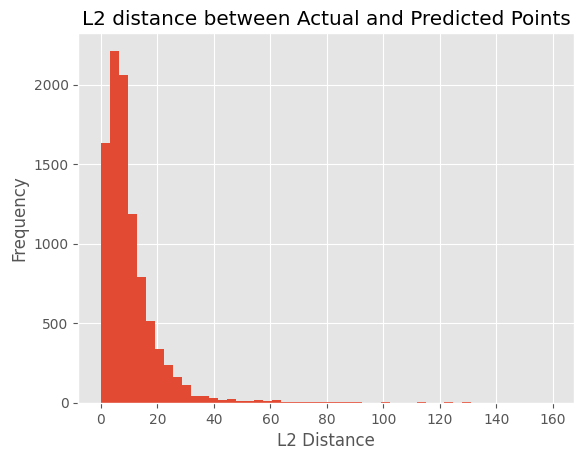

In [ ]:
plt.style.use('ggplot')
plt.hist(df['L2_distance'], bins=50)
plt.title('L2 distance between Actual and Predicted Points')
plt.xlabel('L2 Distance')
plt.ylabel('Frequency')

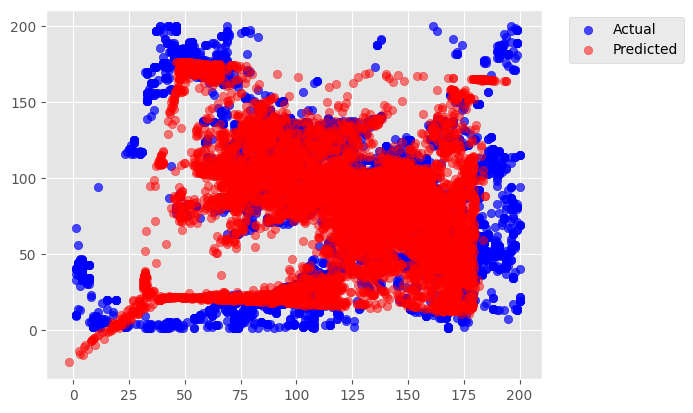

In [ ]:
actual, predicted = np.array(actual), np.array(predicted)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axes[0].scatter(predicted[:, 0], predicted[:, 1], label="Predicted", color="red", alpha=0.5)
axes[0].set_title("Predicted Data")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")
axes[0].legend(loc='upper right')

axes[1].scatter(actual[:, 0], actual[:, 1], label="Actual", color="blue", alpha=0.5)
axes[1].set_title("Actual Data")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].legend(loc='upper right')

axes[2].scatter(actual[:, 0], actual[:, 1], label="Actual", color="blue", alpha=0.5)
axes[2].scatter(predicted[:, 0], predicted[:, 1], label="Predicted", color="red", alpha=0.5)
axes[2].set_title("Actual vs Predicted")
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Y-axis")
axes[2].legend(loc='upper right')

plt.show()